# What is a brain tumor?
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.


# About the Dataset
The Dataset was taken from an open source contribution from kaggle. This dataset is a combination of the following three datasets :



> figshare

>SARTAJ dataset

>Br35H


This dataset contains **7023** images of human brain MRI images which are classified into 4 classes: **glioma** - **meningioma** - **no tumor and pituitary**.

no tumor class images were taken from the Br35H dataset

## Importing Dataset

In [1]:
#@title Download Kaggle Dataset

dataset_name = "masoudnickparvar/brain-tumor-mri-dataset" #@param {type:"string"}
is_compition = False #@param {type:"boolean"}
import requests
import json
!touch /root/.kaggle/kaggle.json
url = 'https://api.jsonbin.io/v3/b/65c29201dc74654018a139c3'
headers = {
  'X-Master-Key': '$2a$10$fl/9DhnD6a6X5doL.Pik7eBmCVn.HHC0X/NsS6q04Okf1BICBHYQ6'
}

try:
    req = requests.get(url, headers=headers)
    req.raise_for_status()  # Raise an exception if the request fails

    # Save the Kaggle credentials to /content/kaggle.json using json.dump()
    with open("/root/.kaggle/kaggle.json", "w+") as kaggle:
        json.dump(req.json()["record"], kaggle)

    print("Kaggle credentials downloaded successfully.")

except requests.exceptions.RequestException as e:
    print("Failed to download Kaggle credentials:", e)
except Exception as e:
    print("An error occurred:", e)

!chmod 600 /root/.kaggle/kaggle.json
zip_name = dataset_name.split('/')[-1]
if is_compition:
  !kaggle competitions download -c {dataset_name}
else:
  !kaggle datasets download -d {dataset_name}
!unzip -q /content/{zip_name}.zip -d /content/{zip_name}
# !rm -r /content/{zip_name}/{zip_name}

'touch' is not recognized as an internal or external command,
operable program or batch file.


An error occurred: [Errno 2] No such file or directory: '/root/.kaggle/kaggle.json'


'chmod' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0




  0%|          | 0.00/149M [00:00<?, ?B/s]
  1%|          | 1.00M/149M [00:01<03:08, 821kB/s]
  1%|▏         | 2.00M/149M [00:01<01:56, 1.32MB/s]
  2%|▏         | 3.00M/149M [00:02<01:36, 1.58MB/s]
  3%|▎         | 4.00M/149M [00:02<01:26, 1.74MB/s]
  3%|▎         | 5.00M/149M [00:03<01:23, 1.80MB/s]
  4%|▍         | 6.00M/149M [00:03<01:16, 1.94MB/s]
  5%|▍         | 7.00M/149M [00:04<01:14, 2.00MB/s]
  5%|▌         | 8.00M/149M [00:04<01:09, 2.13MB/s]
  6%|▌         | 9.00M/149M [00:05<01:05, 2.24MB/s]
  7%|▋         | 10.0M/149M [00:05<01:03, 2.30MB/s]
  7%|▋         | 11.0M/149M [00:05<01:03, 2.29MB/s]
  8%|▊         | 12.0M/149M [00:06<01:06, 2.16MB/s]
  9%|▊         | 13.0M/149M [00:06<01:04, 2.19MB/s]
  9%|▉         | 14.0M/149M [00:07<00:59, 2.37MB/s]
 10%|█         | 15.0M/149M [00:07<00:58, 2.38MB/s]
 11%|█         | 16.0M/149M [00:08<00:58, 2.39MB/s]
 11%|█▏        | 17.0M/149M [00:08<00:58, 2.36MB/s]
 12%|█▏        | 18.0M/149M [00:09<00:56, 2.40MB/s]
 13%|█▎        | 19.0

In [3]:
!Expand-Archive -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

'Expand-Archive' is not recognized as an internal or external command,
operable program or batch file.


## Importing Modules for training

In [94]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score as acc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

### Defining Constants

In [95]:
# Defining Constants
TRAIN = 'brain-tumor-mri-dataset/Training'
TEST = 'brain-tumor-mri-dataset/Testing'

BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)

CHANNELS = 3

## Importing Dataset into dataframes

In [96]:
import os
import pandas as pd

def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)

    for fold in folds:
        foldpath = os.path.join(data_path, fold)
        filelist = os.listdir(foldpath)

        for fpath in filelist:
            fullpath = os.path.join(foldpath, fpath)
            filepaths.append(fullpath)
            labels.append(fold)

    file_series = pd.Series(filepaths, name='filepaths')
    label_series = pd.Series(labels, name='labels')
    return pd.concat([file_series, label_series], axis=1)

train_df = create_dataframe(TRAIN)
test_df = create_dataframe(TEST)

In [97]:
val_df, train_df = train_test_split(train_df, train_size=0.25, random_state=69)

## Creating Image Generator for Training and Validation

In [98]:
train_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

train_generator = train_generator.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)
valid_generator = test_generator.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= True, batch_size= BATCH_SIZE)

Found 4284 validated image filenames belonging to 4 classes.
Found 1428 validated image filenames belonging to 4 classes.


## Defining Model architecture

We use three 5 layers architecture with three layers being convolution layers and the last three dense layers, and last as the 4 ouput dense layer.



In [102]:


inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS))

# Block 1
x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Block 2
x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Block 3
x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)


x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

# Output layer
prediction = Dense(4, activation='softmax')(x)

# Create the model
BTCModel = Model(inputs=inputs, outputs=prediction)

# Print the summary
BTCModel.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 455,108 (1.74 MB)

 Trainable params: 454,212 (1.73 MB)

 Non-trainable params: 896 (3.50 KB)

In [103]:
optim = Adam(learning_rate= 0.001)
loss = 'crossentropy'
metrics = ['accuracy']

BTCModel.compile(optimizer = optim, loss= loss, metrics= metrics)

In [104]:
history = BTCModel.fit(train_generator, validation_data = valid_generator, epochs=50, shuffle = False)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.5810 - loss: 0.9992 - val_accuracy: 0.4041 - val_loss: 1.8057
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.7224 - loss: 0.7097 - val_accuracy: 0.7129 - val_loss: 0.6123
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.7732 - loss: 0.5849 - val_accuracy: 0.5168 - val_loss: 3.4165
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.7999 - loss: 0.5218 - val_accuracy: 0.4734 - val_loss: 1.6426
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.8126 - loss: 0.4796 - val_accuracy: 0.6443 - val_loss: 0.9160
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.8344 - loss: 0.4402 - val_accuracy: 0.8824 - val_loss: 0.3320
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.8618 - loss: 0.3714 - val_accuracy: 0.6877 - val_loss: 1.4714
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.8475 - loss: 0

In [106]:
epochs = list(range(1, 51))
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

df = pd.DataFrame({
    'Epochs': epochs,
    'Training Accuracy': accuracy,
    'Validation Accuracy': val_accuracy
})


fig = px.line(df, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
              markers=True,
              title='Accuracy over Epochs',
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              )


fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=epochs, gridcolor='gray', gridwidth=0.5),
    yaxis=dict(title='Accuracy', gridcolor='gray', gridwidth=0.5),
    legend_title='Data Type',
    hovermode='x',
    title_font_size=20,
    font=dict(size=14),
)

fig.show()


In [107]:
epochs = list(range(1, 51))
loss = history.history['loss']
val_loss = history.history['val_loss']

df = pd.DataFrame({
    'Epochs': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

fig = px.line(df, x='Epochs', y=['Training Loss', 'Validation Loss'],
              markers=True,
              title='Loss Over Epochs',
              labels={'value': 'Loss', 'variable': 'Dataset'},
              )

fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=epochs, gridcolor='gray', gridwidth=0.5),
    yaxis=dict(title='Loss', gridcolor='gray', gridwidth=0.5),
    legend_title='Data Type',
    hovermode='x',
    title_font_size=20,
    font=dict(size=14),
)


fig.show()


In [108]:
test_generator = ImageDataGenerator()
test_generator = test_generator.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= IMG_SIZE, class_mode= 'sparse', color_mode= 'rgb', shuffle= False, batch_size= BATCH_SIZE)

Found 1311 validated image filenames belonging to 4 classes.


In [110]:
prediction = BTCModel.predict(test_generator)
y_predicted = np.argmax(prediction, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


In [111]:
dictionary = test_generator.class_indices
classes = list(dictionary.keys())

accuracy = acc(test_generator.classes, y_predicted)
print("Accuracy = ", accuracy)
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_predicted, target_names=classes))


Accuracy =  0.8428680396643783

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.67      0.80       300
  meningioma       0.63      0.80      0.71       306
     notumor       0.87      1.00      0.93       405
   pituitary       1.00      0.84      0.91       300

    accuracy                           0.84      1311
   macro avg       0.87      0.83      0.84      1311
weighted avg       0.87      0.84      0.84      1311



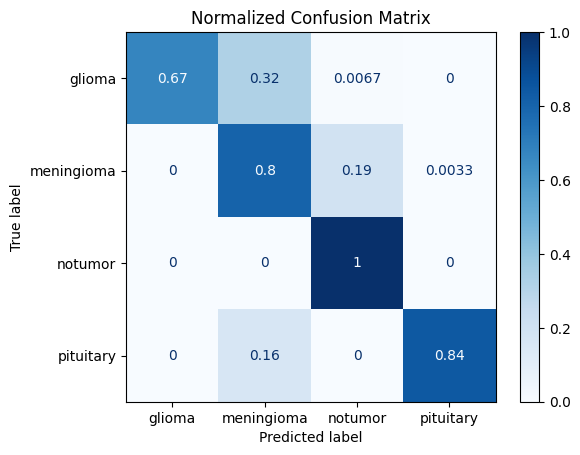

In [112]:
cm = confusion_matrix(test_generator.classes, y_predicted, labels=list(dictionary.values()), normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

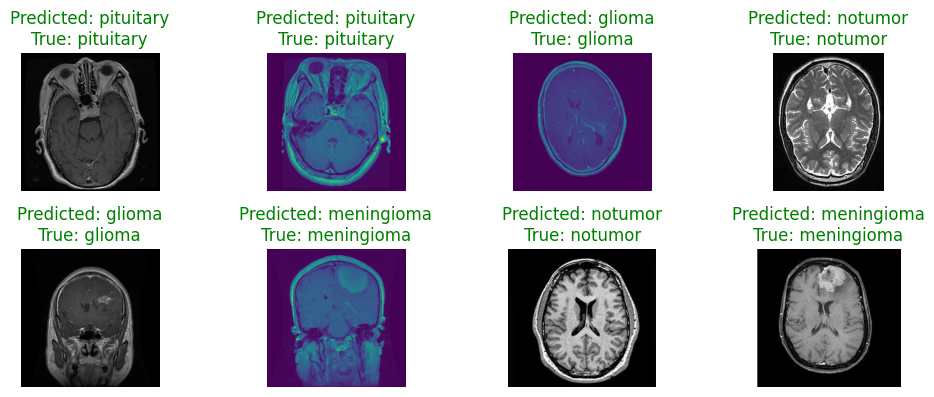

In [113]:
def testingWithPlot(test_generator, y_predicted, categories):

    sample_indices = np.random.choice(len(test_generator.filepaths), size=8, replace=False)

    plt.figure(figsize=(10, 8))

    for i, index in enumerate(sample_indices):
        img = plt.imread(test_generator.filepaths[index])
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

        predicted_label = categories[y_predicted[index]]
        true_label = categories[test_generator.classes[index]]
        prediction_color = 'green' if predicted_label == true_label else 'red'
        plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}", color=prediction_color)

    plt.tight_layout()
    plt.show()

testingWithPlot(test_generator, y_predicted, classes)

In [116]:
BTCModel.save('/content/drive/MyDrive/AI CEP/brain_tumor_v2.keras')

In [117]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AI CEP/brain_tumor_v2.keras')

In [118]:
def predict_from_file(file):
  img = tf.keras.utils.load_img(file, target_size=IMG_SIZE)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
  )
predict_from_file('/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to glioma with a 47.54 percent confidence.
